#### 读取数据

In [1]:
import pandas as pd
import numpy as np

In [2]:
reviews=pd.read_csv('../results/review_featured.csv')
reviews.head()

,vec1,vec2,vec3,vec4,vec5,length,sentiment,label
0,-0.127523,0.116281,0.228301,-0.189753,-0.166368,8.0,0.895109,AI
1,0.025837,0.144995,0.182878,-0.155422,-0.053922,9.0,0.950544,AI
2,-0.045734,-0.073166,0.071311,-0.209206,0.036670,15.0,0.949517,AI
3,-0.158780,0.050875,0.043675,-0.078188,0.037930,7.0,0.948380,AI
4,0.005423,-0.065615,-0.037163,-0.052784,0.086326,17.0,0.269619,AI


随机选取和human个数相同的AI评论，使类别平衡

In [3]:
# 查看样本数量  
ai_count = reviews[reviews['label'] == 'AI'].shape[0]  
human_count = reviews[reviews['label'] == 'Human'].shape[0]  

print(f"Original counts: AI={ai_count}, Human={human_count}")  

# 如果数量不相等，进行重抽样  
if ai_count < human_count:  
    # 获取 Human 的样本  
    human_samples = reviews[reviews['label'] == 'Human']  
    
    # 进行重抽样，替换抽样  
    ai_samples = reviews[reviews['label'] == 'AI']  
    ai_resampled = ai_samples.sample(n=human_count, replace=True, random_state=42)  
    
    # 合并样本  
    balanced_reviews = pd.concat([human_samples, ai_resampled])  
else:  
    # 如果"Human"样本更多或相同，保持原样  
    balanced_reviews = reviews  

# 输出平衡后的结果  
print(f"Balanced counts: AI={balanced_reviews[balanced_reviews['label'] == 'AI'].shape[0]}, Human={balanced_reviews[balanced_reviews['label'] == 'Human'].shape[0]}")

Original counts: AI=562, Human=5248
Balanced counts: AI=5248, Human=5248


In [4]:
X=balanced_reviews.drop('label',axis=1)
y=balanced_reviews['label']

PCA降维可视化

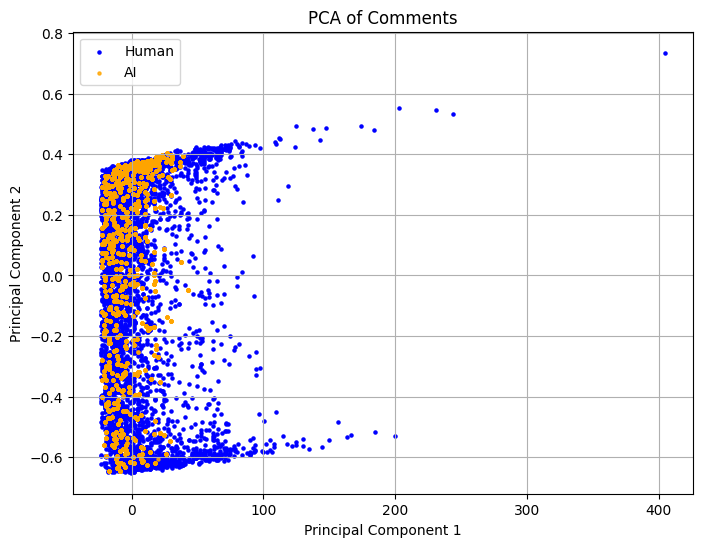

In [5]:
import numpy as np  
import pandas as pd  
from sklearn.decomposition import PCA  
import matplotlib.pyplot as plt  
  
# 使用 PCA 降维到 2 维  
pca = PCA(n_components=2)  
X_reduced = pca.fit_transform(X)  

# 假设 y 里面有 0 和 1 两种类别  
# 绘制散点图  
plt.figure(figsize=(8, 6))  
plt.scatter(X_reduced[y == "Human", 0], X_reduced[y == "Human", 1], label='Human', color='blue', alpha=1,s=5)  
plt.scatter(X_reduced[y == "AI", 0], X_reduced[y == "AI", 1], label='AI', color='orange', alpha=0.8,s=5)  

plt.title('PCA of Comments')  
plt.xlabel('Principal Component 1')  
plt.ylabel('Principal Component 2')  
plt.legend()  
plt.grid()  
plt.show() 

### 训练模型

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  
from xgboost import XGBClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier,plot_tree
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

#### 划分测试集训练集

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

In [28]:
pd.DataFrame(y_test).value_counts()

label
AI       1050
Human    1050
Name: count, dtype: int64

#### 逻辑回归

In [29]:
param_grid={'C':[0.1,0.5,1,5,10,50,100,500,1000,1e10]}
kfold=KFold(n_splits=10,random_state=1,shuffle=True)
model1=GridSearchCV(LogisticRegression(fit_intercept=True,max_iter=1000),param_grid,cv=kfold)
model1.fit(X_train,y_train)
y_pred=model1.predict(X_test)
print('best_C:',model1.best_params_)
print(classification_report(y_test,y_pred))
print('准确率:',model1.score(X_test,y_test))

best_C: {'C': 0.5}
              precision    recall  f1-score   support

          AI       0.62      0.66      0.64      1050
       Human       0.64      0.59      0.62      1050

    accuracy                           0.63      2100
   macro avg       0.63      0.63      0.63      2100
weighted avg       0.63      0.63      0.63      2100

准确率: 0.6295238095238095


[[624 426]
 [352 698]]


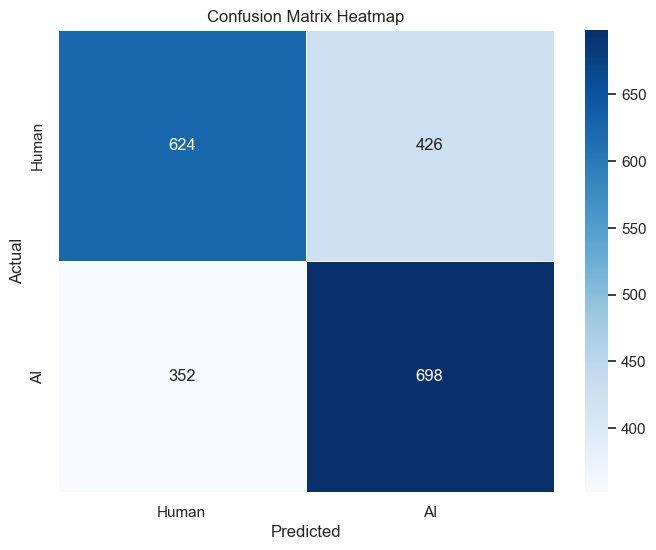

In [30]:
# 计算混淆矩阵  
cm = confusion_matrix(y_test, y_pred,labels=["Human",'AI'])  
print(cm)
# 将混淆矩阵转换为 DataFrame，便于可视化  
cm_df = pd.DataFrame(cm, index=["Human",'AI'], columns=[ 'Human','AI'])  

# 设置热力图的样式  
sns.set(style="white")  

# 创建热力图  
plt.figure(figsize=(8, 6))  
heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)  

# 添加标题和标签  
plt.title('Confusion Matrix Heatmap')  
plt.ylabel('Actual')  
plt.xlabel('Predicted')  
plt.show()  

#### 决策树

准确率: 0.6142857142857143
              precision    recall  f1-score   support

          AI       0.59      0.77      0.67      1050
       Human       0.66      0.46      0.55      1050

    accuracy                           0.61      2100
   macro avg       0.63      0.61      0.61      2100
weighted avg       0.63      0.61      0.61      2100



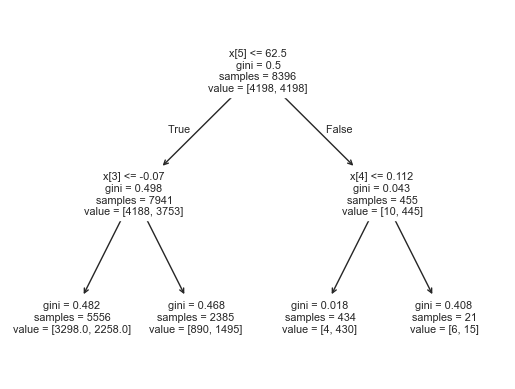

In [31]:
model=DecisionTreeClassifier(max_depth=2,random_state=123)
model.fit(X_train,y_train)
plot_tree(model)
print('准确率:',model.score(X_test,y_test))
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))

In [32]:
model=DecisionTreeClassifier(random_state=123)
path=model.cost_complexity_pruning_path(X_train,y_train)
param_grid={'ccp_alpha':path.ccp_alphas}
kfold=KFold(n_splits=10,random_state=1,shuffle=True)
model1=GridSearchCV(DecisionTreeClassifier(random_state=123,max_depth=5),param_grid,cv=kfold)
model1.fit(X_train,y_train)
y_pred=model1.predict(X_test)
print('best_ccp_alpha:',model1.best_params_)
print(classification_report(y_test,y_pred))
print('准确率:',model1.score(X_test,y_test))

best_ccp_alpha: {'ccp_alpha': 0.0}
              precision    recall  f1-score   support

          AI       0.61      0.86      0.71      1050
       Human       0.75      0.44      0.56      1050

    accuracy                           0.65      2100
   macro avg       0.68      0.65      0.63      2100
weighted avg       0.68      0.65      0.63      2100

准确率: 0.6485714285714286


#### 支持向量机

In [37]:
# 定义参数网格，包含不同核函数的对应参数  
param_grid = [  
    {  
        'kernel': ['linear'],  
        'C': [1, 10,100]  
    },  
    {  
        'kernel': ['rbf'],  
        'C': [ 1, 10] ,  
    },  
    {  
        'kernel': ['poly'],  
        'C': [ 1, 10] ,  
        'degree': [2, 3, 4],  # 可选择的多项式的阶数  
    }  
]  
kfold=KFold(n_splits=10,random_state=1,shuffle=True)
model1=GridSearchCV(SVC(kernel='linear'),param_grid,cv=kfold)
model1.fit(X_train,y_train)
y_pred=model1.predict(X_test)
print('best_C:',model1.best_params_)
print(classification_report(y_test,y_pred))
print('准确率:',model1.score(X_test,y_test))

best_C: {'C': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

          AI       0.62      0.73      0.67      1050
       Human       0.67      0.54      0.60      1050

    accuracy                           0.64      2100
   macro avg       0.64      0.64      0.64      2100
weighted avg       0.64      0.64      0.64      2100

准确率: 0.6390476190476191


[[571 479]
 [279 771]]


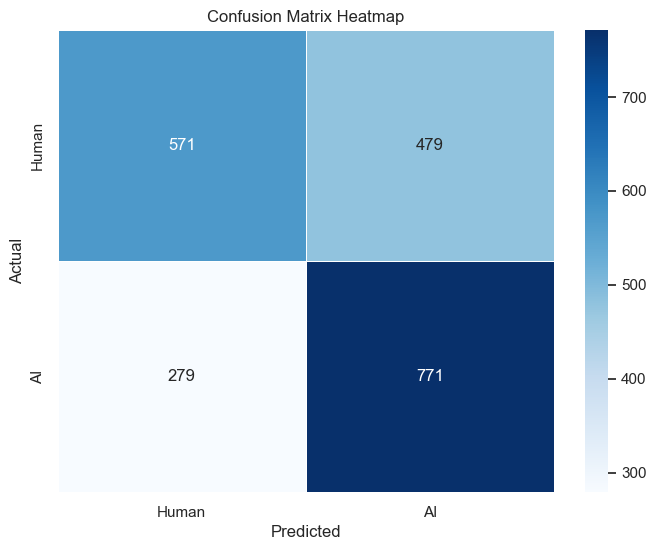

In [38]:
# 计算混淆矩阵  
cm = confusion_matrix(y_test, y_pred,labels=["Human",'AI'])  
print(cm)
# 将混淆矩阵转换为 DataFrame，便于可视化  
cm_df = pd.DataFrame(cm, index=["Human",'AI'], columns=[ 'Human','AI'])  

# 设置热力图的样式  
sns.set(style="white")  

# 创建热力图  
plt.figure(figsize=(8, 6))  
heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)  

# 添加标题和标签  
plt.title('Confusion Matrix Heatmap')  
plt.ylabel('Actual')  
plt.xlabel('Predicted')  
plt.show()  

#### 随机森林

In [33]:
# 创建随机森林分类器  
model = RandomForestClassifier(n_estimators=100, random_state=123)  # 可以调整参数，例如树的数量  

# 训练模型  
model.fit(X_train, y_train)  

# 在测试集上进行预测  
y_pred = model.predict(X_test)  

# 计算准确率  
print('准确率:',model.score(X_test,y_test))
print(classification_report(y_test,y_pred))

准确率: 0.9942857142857143
              precision    recall  f1-score   support

          AI       0.99      1.00      0.99      1050
       Human       1.00      0.99      0.99      1050

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100



[[1038   12]
 [   0 1050]]


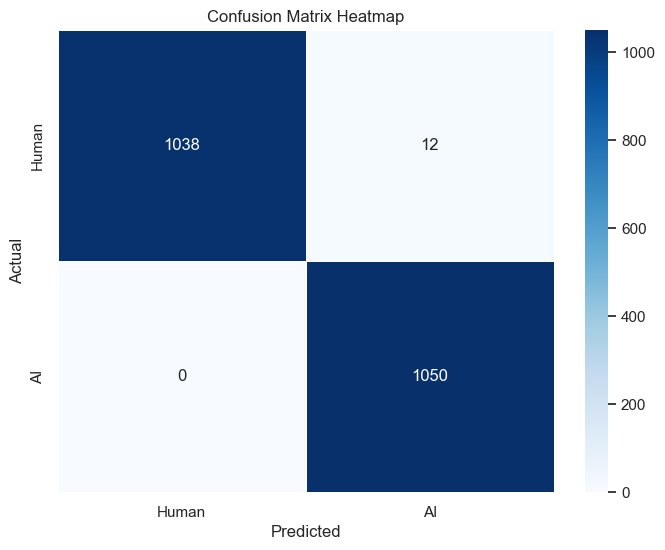

In [34]:
# 计算混淆矩阵  
cm = confusion_matrix(y_test, y_pred,labels=["Human",'AI'])  
print(cm)
# 将混淆矩阵转换为 DataFrame，便于可视化  
cm_df = pd.DataFrame(cm, index=["Human",'AI'], columns=[ 'Human','AI'])  

# 设置热力图的样式  
sns.set(style="white")  

# 创建热力图  
plt.figure(figsize=(8, 6))  
heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)  

# 添加标题和标签  
plt.title('Confusion Matrix Heatmap')  
plt.ylabel('Actual')  
plt.xlabel('Predicted')  
plt.show()  

#### xgboost

In [35]:
y_test_encoded = pd.Series(y_test).map({'AI': 0, 'Human': 1})  
y_train_encoded = pd.Series(y_train).map({'AI': 0, 'Human': 1})  
# 参数网格定义  
param_grid = {  
    'n_estimators': [100, 300,400,500,600],  
    'gamma': [0, 1, 5]
}  
kfold=KFold(n_splits=10,random_state=1,shuffle=True)
model1=GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123),param_grid,cv=kfold)
model1.fit(X_train,y_train_encoded)
y_pred=model1.predict(X_test)
print('best_n_estimators:',model1.best_params_)
print(classification_report(y_test_encoded,y_pred))
print('准确率:',model1.score(X_test,y_test_encoded))

best_n_estimators: {'gamma': 0, 'n_estimators': 600}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1050
           1       1.00      0.96      0.98      1050

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100

准确率: 0.9785714285714285


[[1005   45]
 [   0 1050]]


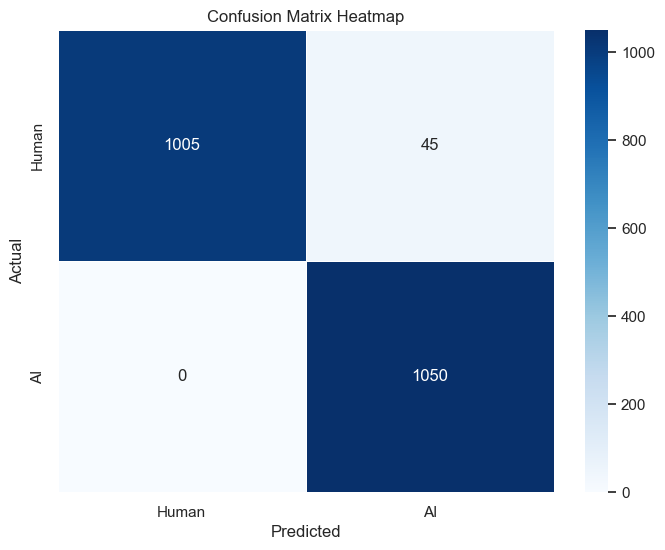

In [36]:
# 计算混淆矩阵  
cm = confusion_matrix(y_test_encoded, y_pred,labels=[1,0])  
print(cm)
# 将混淆矩阵转换为 DataFrame，便于可视化  
cm_df = pd.DataFrame(cm, index=["Human",'AI'], columns=[ 'Human','AI'])  

# 设置热力图的样式  
sns.set(style="white")  

# 创建热力图  
plt.figure(figsize=(8, 6))  
heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)  

# 添加标题和标签  
plt.title('Confusion Matrix Heatmap')  
plt.ylabel('Actual')  
plt.xlabel('Predicted')  
plt.show()  